In [1]:
do_data_cdf = "/home/benr/wqmodels/ssm/freshwater_iav_1/conc_tests/fulldepthdo2.nc"
do_variables = ('q0.1_same_conc','q0.1_same_load',
                'control',
                'q0.9_same_conc', 'q0.9_same_load')
#do_variables = 'control'
control_variable = 'control'
variable_type = 'DOXG'
out_path = '/home/benr/wqmodels/ssm/freshwater_iav_1/conc_tests/'

start_date = "2012-01-01"
grid_file = 'SSM_Grid/ssm_grid.2dm'

from pathlib import Path
import os.path as path
import os
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import cmocean
import matplotlib.colors as colors

from fvcom.grid import FvcomGrid
from fvcom.depth import DepthCoordinate
from fvcom.control_volume import ControlVolume, StationHelper

In [2]:
do_data = Dataset(do_data_cdf)
do_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2012-01-01 00:00:00
    dimensions(sizes): time(10967), node(3137), nele(4129), siglay(10), siglev(11)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 siglay(siglay), float32 siglev(siglev), float32 zeta(time, node), float32 controlDOXG(time, siglay, node), float32 q0.1_same_concDOXG(time, siglay, node), float32 q0.1_same_loadDOXG(time, siglay, node), float32 q0.9_same_loadDOXG(time, siglay, node), float32 q0.9_same_concDOXG(time, siglay, node)
    groups: 

In [3]:
timestep = do_data['time'][2] - do_data['time'][1]
times = do_data['time'][:]
dates = pd.Timestamp(start_date) + pd.to_timedelta(times, 'd')
timestep

0.04168701

In [4]:
if type(do_variables) == str:
    do_variables = (do_variables,)
control_variable += variable_type if not control_variable.endswith(variable_type) else ''
do_variables = [v + (variable_type if not v.endswith(variable_type) else '') for v in do_variables]
assert control_variable in do_variables, f"Control variable '{control_variable}' should be present in do_variables."

In [5]:
out_base = Path(do_data_cdf).stem
if not path.isdir(out_path):
    os.mkdir(out_path)
out_file = lambda name: path.join(out_path, out_base + "_fulldo_" + name)

In [6]:
do_variable_titles = [s.removesuffix(variable_type) for s in do_variables]
control_title = control_variable.removesuffix(variable_type)
do_variable_titles

['q0.1_same_conc',
 'q0.1_same_load',
 'control',
 'q0.9_same_conc',
 'q0.9_same_load']

In [7]:
grid = FvcomGrid.from_mesh(grid_file)
cv = ControlVolume(grid=grid, nodes=set(do_data['node'][:]), calc=True)
dcoord = DepthCoordinate.from_output(do_data, grid=grid)
domain = cv.tces
domain.head()

,geometry
4478,"POLYGON ((516205.333 5332870.667, 516422.500 5..."
4479,"POLYGON ((516296.000 5333811.000, 516532.000 5..."
4480,"POLYGON ((516619.500 5334914.000, 516686.667 5..."
4481,"POLYGON ((517313.667 5335642.333, 517722.500 5..."
4482,"POLYGON ((517846.000 5336754.333, 518219.500 5..."


In [8]:
# get siglev thickness at each node, use to calculate volume of each cell
grid3d = np.expand_dims(dcoord.dz, 1) @ np.expand_dims(do_data['h'], 0)
# cell volume in m3
cellvols = grid3d * domain.area.to_numpy()
# Total volume in km3
total_volume = cellvols.sum() / 1e9
total_volume_2 = np.expand_dims(domain.area.to_numpy(), 0) @ np.expand_dims(do_data['h'], 1) / 1e9
assert (total_volume - total_volume_2) / total_volume < 0.0001, f"{total_volume} != {total_volume_2}"

def extract_data(var):
    return do_data[var][:].data

# Calculate the total time that this retrieved node index spent with a hypoxic DO
def calc_duration(data, i):
    return (np.count_nonzero(data[:,:,i] < 2) * timestep).min(axis=1)

def calc_volume(data, t):
    return cellvols[data[t,:,:] < 2].sum() / 1e9

extracted_data = {}
hypoxic_volumes = {}

for v in do_variables:
    extracted_data[v] = extract_data(v)
    hypoxic_volumes[v] = np.zeros(extracted_data[v].shape[0])
    for t in range(len(hypoxic_volumes[v])):
        hypoxic_volumes[v][t] = calc_volume(extracted_data[v], t)

hypoxic_volumes_df = pd.DataFrame(hypoxic_volumes, index=dates)

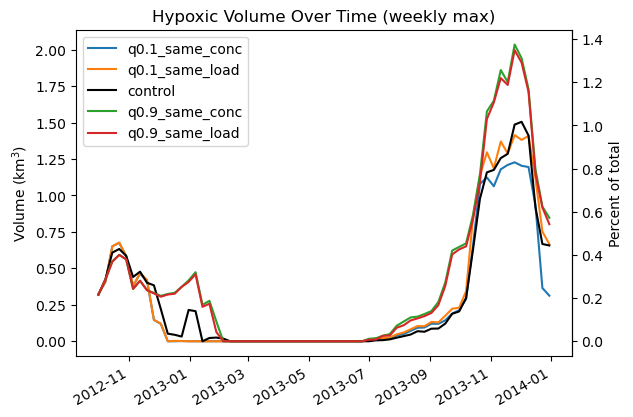

In [9]:
fig, ax = plt.subplots()
hypoxic_volumes_weekly = hypoxic_volumes_df.groupby(hypoxic_volumes_df.index.to_period('W')).max()
hypoxic_volumes_weekly.set_index(hypoxic_volumes_weekly.index.to_timestamp('D', 's'), inplace=True)
for v, t in zip(do_variables, do_variable_titles):
    if t == control_title:
        color = 'black'
    else:
        color = None
    ax.plot(hypoxic_volumes_weekly[v], color=color, label=t)
ax.set(title="Hypoxic Volume Over Time (weekly max)", ylabel="Volume (km$^3$)")
fig.autofmt_xdate()
ax.legend()

# Build a secondary y-axis with the total volume percentage
def vol_to_pct(a):
    return a * 100 / total_volume
def pct_to_vol(p):
    return p / 100 * total_volume

secax = ax.secondary_yaxis('right', functions=(vol_to_pct, pct_to_vol))
secax.set_ylabel("Percent of total")
fig.savefig(out_file("hypoxic_volume.png"))
hypoxic_volumes_df.to_excel(out_file("hypoxic_volume.xlsx"))

In [10]:
do_data.close()